# To do
1. Plot weekdays and weekends separately for the bus tracker

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sodapy import Socrata

First, I will look at which areas in Chicago have the worst traffic problems. Past congestion data, from bus tracking, is at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi.

Unfortunately, this dataset hasn't been updated since 2015 (there is a live tracking feed for current conditions). Also, there are big glitches where the data from 2015 are all labeled as being from January, and all data from 2013 and 2014 are labeled as being taken at 11pm. I have used the 2015 data, assuming that the entries are essentially correct aside from the month and that the data is still representative of the traffic patterns.

Region ID correspondence is given at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd.

In [47]:
#Look at historical congestion data
df_cong = pd.read_csv('Data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')

In [48]:
#Parse TIME
cong_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df_cong['TIME'] = df_cong['TIME'].apply(cong_parser)

In [49]:
df_cong['year'] = df_cong['TIME'].apply(lambda x: x.year)
df_cong['hour'] = df_cong['TIME'].apply(lambda x: x.hour)

In [50]:
#Limit myself to 2015
df_cong = df_cong[df_cong.year == 2015]

Make plots of average bus speeds by hour, for 4 centrally located areas.

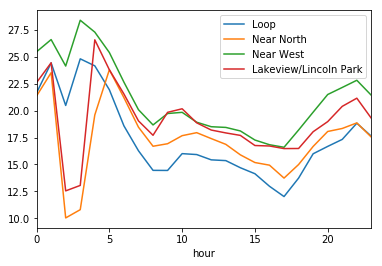

In [55]:
df_cong[(df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.legend()
plt.show()

The dips in early morning appear because very few buses are being tracked; some rows show 0.0 as the average speed. These are artifacts of the data taking process and is not indicative of the traffic condition.

Some features in the graphs are obvious if you spend any time in the city:
1. There is a small dip at 8-9am for the morning commute.
2. There is a deeper dip around 5pm.

Comparing also with plots for other areas shows that Near West and Lakeview/Lincoln Park are not especially congested, which is mildly surprising. The Loop is identified as uniquely congested (no surprise), with Near North also standing out in second place.

This is a statement about average speeds, and it is an open question whether areas outside the top 2 experience similarly bad traffic. Event traffic (e.g. Cubs home games in Lakeview) can be significant for short periods of time.

In [218]:
#Select the Loop only. REGION_ID for the Loop is 13 in this dataset
df_cong_Loop = df_cong[df_cong.REGION_ID == 13]

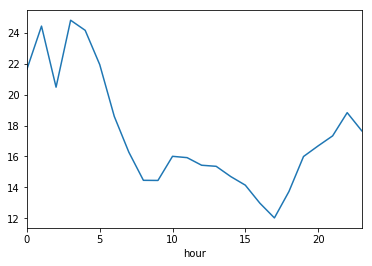

In [219]:
df_cong_Loop.groupby('hour').mean()['SPEED'].plot()
plt.show()

In [220]:
df_cong_Loop.groupby('hour').mean()['SPEED']

hour
0     21.651237
1     24.435860
2     20.483656
3     24.815699
4     24.163817
5     21.943656
6     18.590699
7     16.274839
8     14.455000
9     14.446667
10    16.008065
11    15.922903
12    15.430968
13    15.360699
14    14.697957
15    14.141989
16    12.977043
17    12.021237
18    13.734247
19    15.996075
20    16.680591
21    17.332378
22    18.833871
23    17.659618
Name: SPEED, dtype: float64

Buses are slowest from 4-7pm. There's also a rush in the morning (8-10am), but the buses in the morning are actually moving slightly faster than at 3pm.

It's 4-7pm that I really should focus on for the taxi data as well.

In [43]:
with open('token.txt', 'r') as f:
    token = f.read().strip().split('\n')

In [45]:
#Use Chicago Data Portal API
client = Socrata("data.cityofchicago.org",
                 '3OSw2t66IrAu3NKjLzgZuRBs2',
                 username=token[0],
                 password=token[1])

In [46]:
#Get 100k rows, 2000 at a time, and process each time to get a list of dfs

#List columns I want
columns = ['fare', 'pickup_community_area', 'dropoff_community_area', 'taxi_id', 'trip_id', 'trip_start_timestamp']
dfs = list()

for i in range(50):
    results = client.get("wrvz-psew", limit=2000)
    #Convert to DataFrame
    results_df = pd.DataFrame.from_records(results)
    
    #Keep only the columns I need
    results_df = results_df[columns]
    
    #Throw away rows with missing pickup/dropoff data
    results_df = results_df[((pd.notnull(results_df.pickup_community_area)) & 
                             (pd.notnull(results_df.dropoff_community_area)))]
    #Then select trips to and from the Loop
    results_df = results_df[((results_df['pickup_community_area'] == '32') | 
                       (results_df['dropoff_community_area'] == '32'))]
    dfs.append(results_df)

In [154]:
#Concatenate, with reindexing
df_Loop = pd.concat(dfs, ignore_index=True)

In [155]:
#Make the areas int rather than str
df_Loop['pickup_community_area'] = df_Loop['pickup_community_area'].astype(int)
df_Loop['dropoff_community_area'] = df_Loop['dropoff_community_area'].astype(int)

In [156]:
#Add an hour column
df_Loop['hour'] = df_Loop.trip_start_timestamp.apply(lambda x: int(x[11:13]))

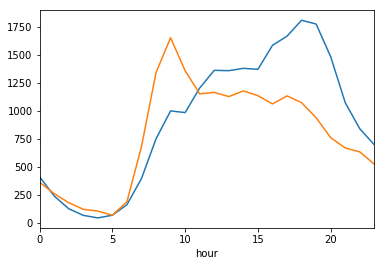

In [157]:
df_Loop[df_Loop.pickup_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
df_Loop[df_Loop.dropoff_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
plt.show()

In [158]:
len(df_Loop)

35429

In [ ]:
#Keep only hour from 16 to 18 (this goes until 18:59).
df_eve_rush = df_Loop[(df_Loop.hour >= 16) & (df_Loop.hour <= 18)]

In [ ]:
#How many are pickups?
print(len(df_eve_rush[df_eve_rush.pickup_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']

In [ ]:
#How many are dropoffs?
print(len(df_eve_rush[df_eve_rush.dropoff_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']

Make maps using Geopandas

In [ ]:
import geopandas

In [ ]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [ ]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']
df_from_Loop = df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']


In [ ]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

In [ ]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.show()

In [ ]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.show()

I should figure out how to zoom in.

In [236]:
plt.legend()

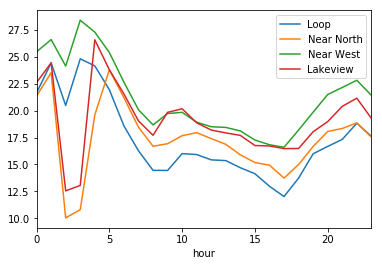

In [267]:
df_cong[(df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview') #Lakeview
plt.legend()
plt.show()

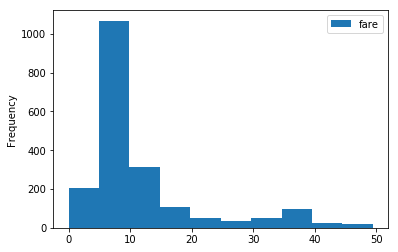

In [205]:
plt.show()

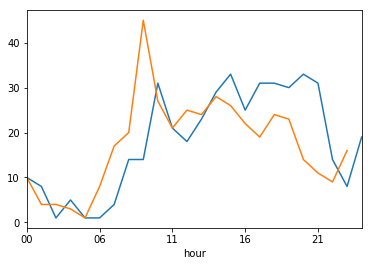

In [214]:
df1[df1.pickup_community_area == '32'].groupby(df1.hour).count()['trip_id'].plot()
df1[df1.dropoff_community_area == '32'].groupby(df1.hour).count()['trip_id'].plot()
plt.show()

Somewhat obviously, there's a peak of dropoffs in the Loop in the morning (9-10am), and there's more pickups than dropoffs in the afternoon-evening (3-10pm).

In [218]:
results = client.get("wrvz-psew", limit=2000)
results_df = pd.DataFrame.from_records(results)
print(results_df.loc[0])

company                                                Northwest Management LLC
dropoff_census_tract                                                17031839100
dropoff_centroid_latitude                                          41.880994471
dropoff_centroid_location     {'type': 'Point', 'coordinates': [-87.63274648...
dropoff_centroid_longitude                                        -87.632746489
dropoff_community_area                                                       32
extras                                                                        1
fare                                                                       4.75
payment_type                                                        Credit Card
pickup_census_tract                                                 17031281900
pickup_centroid_latitude                                           41.879255084
pickup_centroid_location      {'type': 'Point', 'coordinates': [-87.64264899...
pickup_centroid_longitude               

In [219]:
results = client.get("wrvz-psew", limit=2000)
results_df = pd.DataFrame.from_records(results)
print(results_df.loc[0])

company                                               Dispatch Taxi Affiliation
dropoff_census_tract                                                        NaN
dropoff_centroid_latitude                                          41.922686284
dropoff_centroid_location     {'type': 'Point', 'coordinates': [-87.64948872...
dropoff_centroid_longitude                                        -87.649488729
dropoff_community_area                                                        7
extras                                                                      1.5
fare                                                                       6.05
payment_type                                                               Cash
pickup_census_tract                                                         NaN
pickup_centroid_latitude                                           41.922686284
pickup_centroid_location      {'type': 'Point', 'coordinates': [-87.64948872...
pickup_centroid_longitude               

# for real

In [152]:
client = Socrata("data.cityofchicago.org",
                 '3OSw2t66IrAu3NKjLzgZuRBs2',
                 username='satoruphys@gmail.com',
                 password='May25,robbery')

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.


In [153]:
#Get 100k rows, 2000 at a time, and process each time to get a list of dfs

#List columns I want
columns = ['fare', 'pickup_community_area', 'dropoff_community_area', 'taxi_id', 'trip_id', 'trip_start_timestamp']
dfs = list()

for i in range(50):
    results = client.get("wrvz-psew", limit=2000)
    #Convert to DataFrame
    results_df = pd.DataFrame.from_records(results)
    
    #Keep only the columns I need
    results_df = results_df[columns]
    
    #Throw away rows with missing pickup/dropoff data
    results_df = results_df[((pd.notnull(results_df.pickup_community_area)) & 
                             (pd.notnull(results_df.dropoff_community_area)))]
    #Then select trips to and from the Loop
    results_df = results_df[((results_df['pickup_community_area'] == '32') | 
                       (results_df['dropoff_community_area'] == '32'))]
    dfs.append(results_df)

With 50 chunks, this takes about 20s on my laptop. Think about how large I can go.

In [154]:
#Concatenate, with reindexing
df_Loop = pd.concat(dfs, ignore_index=True)

In [155]:
#Make the areas int rather than str
df_Loop['pickup_community_area'] = df_Loop['pickup_community_area'].astype(int)
df_Loop['dropoff_community_area'] = df_Loop['dropoff_community_area'].astype(int)

In [156]:
#Add an hour column
df_Loop['hour'] = df_Loop.trip_start_timestamp.apply(lambda x: int(x[11:13]))

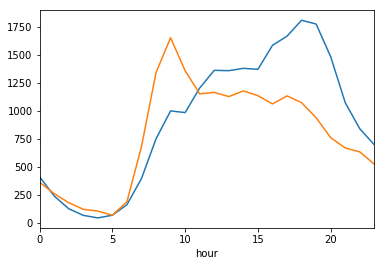

In [157]:
df_Loop[df_Loop.pickup_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
df_Loop[df_Loop.dropoff_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
plt.show()

In [158]:
len(df_Loop)

35429

Historical congestion data is from https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi.

Unfortunately, this hasn't been updated up to 2017 (there is a live feed for current conditions). But I will assume that the traffic patterns are generally similar.

Region ID correspondence is given here. https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd

In [275]:
#Look at historical congestion data
df_cong = pd.read_csv('Data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')

In [277]:
#Parse TIME
cong_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df_cong['TIME'] = df_cong['TIME'].apply(cong_parser)

In [278]:
df_cong['hour'] = df_cong['TIME'].apply(lambda x: x.hour)

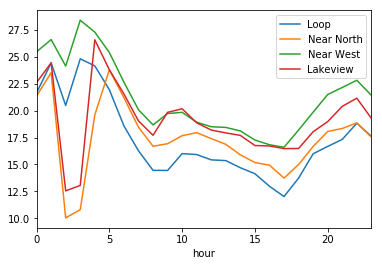

In [267]:
df_cong[(df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview') #Lakeview
plt.legend()
plt.show()

In [279]:
df_cong['year'] = df_cong['TIME'].apply(lambda x: x.year)

In [280]:
df_cong[df_cong.REGION_ID == 13].groupby(['year', 'hour']).count()

TIME  REGION_ID  BUS COUNT  NUMBER OF READS                        \
year hour                                                                       
2013 23    49364      49364      49364                                  49364   
2014 23    51364      51364      51364                                  51364   
2015 0       186        186        186                                    186   
     1       186        186        186                                    186   
     2       186        186        186                                    186   
     3       186        186        186                                    186   
     4       186        186        186                                    186   
     5       186        186        186                                    186   
     6       186        186        186                                    186   
     7       186        186        186                                    186   
     8       186        186        186                                    186   
     9       186        186        186                                    186   
     10      186        186        186                                    186   
     11      186        186        186                                    186   
     12      186        186        186                                    186   
     13      186        186        186                                    186   
     14      186        186        186                                    186   
     15      186        186        186                                    186   
     16      186        186        186                                    186   
     17      186        186        186                                    186   
     18      186        186        186                                    186   
     19      186        186        186                                    186   
     20      186        186        186                                    186   
     21      185        185        185                                    185   
     22      186        186        186                                    186   
     23     4649       4649       4649                                   4649   

           SPEED     ID  
year hour                
2013 23    49364  49364  
2014 23    51364  51364  
2015 0       186    186  
     1       186    186  
     2       186    186  
     3       186    186  
     4       186    186  
     5       186    186  
     6       186    186  
     7       186    186  
     8       186    186  
     9       186    186  
     10      186    186  
     11      186    186  
     12      186    186  
     13      186    186  
     14      186    186  
     15      186    186  
     16      186    186  
     17      186    186  
     18      186    186  
     19      186    186  
     20      186    186  
     21      185    185  
     22      186    186  
     23     4649   4649

In [281]:
df_cong[(df_cong.hour != 23)].groupby('hour').count()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,year
hour,,,,,,,
0,5394,5394,5394,5394,5394,5394,5394
1,5394,5394,5394,5394,5394,5394,5394
2,5394,5394,5394,5394,5394,5394,5394
3,5394,5394,5394,5394,5394,5394,5394
4,5394,5394,5394,5394,5394,5394,5394
5,5394,5394,5394,5394,5394,5394,5394
6,5394,5394,5394,5394,5394,5394,5394
7,5394,5394,5394,5394,5394,5394,5394
8,5394,5394,5394,5394,5394,5394,5394


Region 12 (Near North) and 13 (Chicago Loop) are the most problematic areas for traffic, at least on average.

Whether this holds at all times is an open question. Event traffic can be significant for short periods of time.

In [218]:
#Select the Loop only. REGION_ID for the Loop is 13 in this dataset
df_cong_Loop = df_cong[df_cong.REGION_ID == 13]

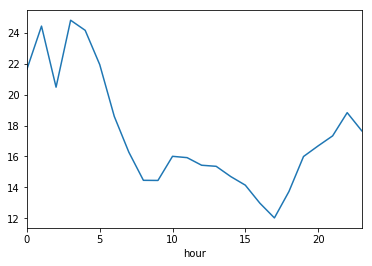

In [219]:
df_cong_Loop.groupby('hour').mean()['SPEED'].plot()
plt.show()

In [220]:
df_cong_Loop.groupby('hour').mean()['SPEED']

hour
0     21.651237
1     24.435860
2     20.483656
3     24.815699
4     24.163817
5     21.943656
6     18.590699
7     16.274839
8     14.455000
9     14.446667
10    16.008065
11    15.922903
12    15.430968
13    15.360699
14    14.697957
15    14.141989
16    12.977043
17    12.021237
18    13.734247
19    15.996075
20    16.680591
21    17.332378
22    18.833871
23    17.659618
Name: SPEED, dtype: float64

Buses are slowest from 4-7pm. There's also a rush in the morning (8-10am), but the buses in the morning are actually moving slightly faster than at 3pm.

It's 4-7pm that I really should focus on for the taxi data as well.

In [ ]:
#Keep only hour from 16 to 18 (this goes until 18:59).
df_eve_rush = df_Loop[(df_Loop.hour >= 16) & (df_Loop.hour <= 18)]

In [ ]:
#How many are pickups?
print(len(df_eve_rush[df_eve_rush.pickup_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']

In [ ]:
#How many are dropoffs?
print(len(df_eve_rush[df_eve_rush.dropoff_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']

Make maps using Geopandas

In [ ]:
import geopandas

In [ ]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [ ]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']
df_from_Loop = df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']


In [ ]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

In [ ]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.show()

In [ ]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.show()

I should figure out how to zoom in.

In [236]:
plt.legend()